In [75]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC

from joblib import dump, load

In [76]:
df_model = pd.read_pickle('../data/df_treated_nulls.pkl')
df_model.head(3)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0


In [77]:
target = df_model["is_promoted"]
df_no_target = df_model.copy()
df_no_target.drop(columns = ["is_promoted", "employee_id"], inplace = True);

In [78]:
df_no_target.shape[1]

11

In [79]:
df_model.shape[1]

13

**Proporción de promociones**

In [80]:
target.value_counts(normalize = True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

No está balanceada. Para ver errores, utilizaremos esta función:

$$ error(y, y_{est}) = \beta * FP + FN $$

Donde:

   * `FP`: false positive. Predicción es *promociona* pero en realidad *no promociona*
   * `FN`: false negative. Predicción es *no promociona* pero en realidad *promociona*

Nos importan $\beta$ veces más los falsos positivos que los falsos negativos. Es decir, predecir que alguien promociona cuando en realidad NO promociona lo consideramos peor que predecir que alguien NO promociona cuando en realidad va a promocionar.

Queremos maximizar la sensibilidad del modelo para evitar los falsos positivos:

$$ Sensitivity = \frac{(TP)}{(TP + FN)} $$

De todos los positivos que había... ¿qué porcentaje hemos encontrado?

En cambio si maximizaramos la precisión del modelo:

Queremos maximizar la sensibilidad del modelo para evitar los falsos positivos:

$$ Precision = \frac{(TP)}{(TP + FP)} $$

De todos los que hemos predicho que eran positivos... ¿qué porcentaje hemos acertado?

# Preguntar -> yo creo que queremos maximizar precisión

**Encoding variables**

Categorical variables:
   * department
   * region
   * education (has nan)
   * gender
   * recruitment_channel

In [81]:
 from sklearn import preprocessing

In [151]:
def encodeCategoricalVariable(variable_to_encode, dataframe, one_hot_encoding):
    '''Encodes a variable from the main df and returns an array with the encoded variables.

        Parameters:
                variable_to_encode (string): name of the column from main df to encode
                dataframe (DataFrame): dataframe with all the information
                one_hot_encoding (boolean): True if a one_hot_encoding encoding is to be performed. False for integer encoding

        Returns:
                encoded_variable (array): array with numerical values from encoded column. It can be 2D array if binary encoding is used
    '''
    if one_hot_encoding:
        le = preprocessing.LabelBinarizer() # Creamos un label encoder
    else:
        le = preprocessing.LabelEncoder() # Creamos un label encoder
    
    le.fit(dataframe[variable_to_encode])    # Lo ajustamos a la variable en cuestión
    encoded_variable = le.transform(dataframe[variable_to_encode]) # Transformamos la variable 
    
    # Se guarda el encoder para usarlo en el programa del dashboard
    file_name = "encoder_variable_" + variable_to_encode
    dump(le, '../data/'+ file_name + ".joblib") 
    
    return encoded_variable


In [158]:
def includeEncodedVariablesInDataframe(variable_that_was_encoded, dataframe_where_to_include, encoded_array):
    '''Includes an encoded variable in the specified dataframe.
    asdasdad

        Parameters:
                variable_that_was_encoded (string): name of the column that was encoded
                dataframe_where_to_include (DataFrame): df where to include the encoded variable
                encoded_array (array): array with the encoding of the  variable. It can be binary or not. It accepts 2D and 1D arrays

        Returns:
                df_to_return (DataFrame): dataframe_where_to_include with the encoded variables included
    '''    
    
    # The shape of the encoded array shape tuple is 2 if it is a binary encoded variable with several categories
    # binary_variable will be True if encoded_array is a 2D array. It will be False if it is a 1D array
    binary_variable = (len(encoded_array.shape) == 2)
    
    if binary_variable:
        
        # We obtain the number of binary values (number of columns to add to the dataframe)
        num_binary_values = encoded_array.shape[1]
        
        # We create the names for the columns
        list_of_names = [ variable_that_was_encoded + "_" + str(index) for index in range(num_binary_values)]
        
        # We create the dataframe
        binary_dataframe = pd.DataFrame(data = encoded_array, columns = list_of_names)
        
        
        # We combine the dataframes
        df_to_return = dataframe_where_to_include.join(binary_dataframe, how='outer')
        
        # Return the final df
        return df_to_return
        
    else:
        dataframe_where_to_include[variable_that_was_encoded] = encoded_array
        df_to_return = dataframe_where_to_include.copy()
        
        
        return df_to_return
        

Ejemplo de uso:

In [84]:
df_no_target.head(3)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0


In [85]:
encoded_variable = encodeCategoricalVariable("department", df_no_target, True)

In [86]:
includeEncodedVariablesInDataframe("department", df_no_target, encoded_variable).head(3)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_0,department_1,department_2,department_3,department_4,department_5,department_6,department_7,department_8
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0,0,0,0,0,0,0,1,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0,0,0,0,1,0,0,0,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0,0,0,0,0,0,0,1,0


Construimos listas para automatizar la llamada a las funciones:

In [87]:
# He decidido no tener en cuenta región. Apenas hay grandes diferencias, no aporta mucho al modelo y la manera correcta sería con one-hot encoding. 
# Esto supone un aumento considerable de variables que no aporta excesivamente y corremos el riesgo de overfitting.
#variables_to_encode = ["department", "region","education", "gender", "recruitment_channel"]
#binary_encodings = [True, False,True , False, False, True]
variables_to_encode = ["department","education", "gender", "recruitment_channel"]
binary_encodings = [True,True , False, False, True]

In [88]:
df_encoded_all_vars = df_no_target.copy()

for i in range(len(variables_to_encode)):
    variable = variables_to_encode[i]
    binary_encoding = binary_encodings[i]
    
    encoded_variable = encodeCategoricalVariable(variable, df_encoded_all_vars, True)
    df_encoded_all_vars = includeEncodedVariablesInDataframe(variable, df_encoded_all_vars, encoded_variable).copy()

In [89]:
df_encoded_all_vars.head(3)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,...,department_7,department_8,education_0,education_1,education_2,education_3,gender_0,recruitment_channel_0,recruitment_channel_1,recruitment_channel_2
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,...,1,0,0,0,1,0,0,0,0,1
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,...,0,0,1,0,0,0,1,1,0,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,...,1,0,1,0,0,0,1,0,0,1


Eliminamos las variables string que ya han sido codificadas

In [90]:
variables_to_encode.append("region") # He añadido esto para quitar también region

In [91]:
df_encoded = df_encoded_all_vars.drop(variables_to_encode, axis=1)

In [92]:
df_encoded.head()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_0,department_1,department_2,department_3,...,department_7,department_8,education_0,education_1,education_2,education_3,gender_0,recruitment_channel_0,recruitment_channel_1,recruitment_channel_2
0,1,35,5.0,8,0,49.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
1,1,30,5.0,4,0,60.0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
2,1,34,3.0,7,0,50.0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,1
3,2,39,1.0,10,0,50.0,0,0,0,0,...,1,0,1,0,0,0,1,1,0,0
4,1,45,3.0,2,0,73.0,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0


**Separación en test/train**

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded,target,test_size = 0.33,random_state = 123) # Random state es para repetir siempre el mismo resultado

In [94]:
df_encoded.isna().sum()

no_of_trainings          0
age                      0
previous_year_rating     0
length_of_service        0
awards_won               0
avg_training_score       0
department_0             0
department_1             0
department_2             0
department_3             0
department_4             0
department_5             0
department_6             0
department_7             0
department_8             0
education_0              0
education_1              0
education_2              0
education_3              0
gender_0                 0
recruitment_channel_0    0
recruitment_channel_1    0
recruitment_channel_2    0
dtype: int64

**PCA**

Se ha decidido no hacer PCA debido a que aporta relativamente poco en combinación con los encodings realizados (aunque hagamos una normalización previa)

De todas maneras, se deja el código por si acaso fuera necesario más tarde o cambiaramos de opinión

In [95]:
do_pca = False

In [96]:
if do_pca:
    pca = PCA(n_components=2)
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train),columns = ["pca1","pca2"])
    X_test_pca = pd.DataFrame(pca.transform(X_test), columns = ["pca1","pca2"])
    
    print("Varianza explicada: ")
    print(pca.explained_variance_ratio_.cumsum()) # Buena cantidad de varianza explciada
    
    # Voy a asignar colores para cada clase, que recordamos son los valores 0, 1 y 2

    colores = {
        0 : "firebrick",
        1 : "steelblue",
        2 : "mediumseagreen"
    }

    # Asigno otro diccionario para las categorías

    cat = {
        0 : "Not Promoted",
        1 : "Promoted",
    }

    # Creamos un gráfico de puntos para representar las relaciones entre esas dos variables
    fig = go.Figure()

    # Representamos los datos de train con círculos

    fig.add_trace(
        go.Scatter(
            x = X_train_pca["pca1"],
            y = X_train_pca["pca2"],
            mode = "markers",
            marker_color = y_train.map(colores), # Asigno los colores según la clase
            marker_symbol = "circle",
            text = y_train.map(cat),
            hovertemplate = "Categoria: %{text}",
            name = "Train"
        )
    )

    # Representamos los datos de test con triángulos

    fig.add_trace(
        go.Scatter(
            x = X_test_pca["pca1"],
            y = X_test_pca["pca2"],
            mode = "markers",
            marker_color = y_test.map(colores), # Asigno los colores según la clase
            marker_symbol = "triangle-up",
            text = y_test.map(cat),
            hovertemplate = "Categoria: %{text}",
            name = "Test"
        )
    )

    # Añadimos información en los ejes para completar el diseño

    fig.update_layout(title = "Representación de los datos de Iris en 2 dimensiones", xaxis_title = "PCA 1", yaxis_title = "PCA 2")

    # Mostramos la figura por pantalla

    fig.show()
    

**Normalización**

In [97]:
# Guardamos las variables por si acaso son necesarias más adelante
X_train_pre_transform = X_train
X_test_pre_transform = X_test

In [98]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test = sc.transform(X_test.values)

In [99]:
dump(sc, '../data/standard_scaler_modelos.joblib') 

['../data/standard_scaler_modelos.joblib']

In [100]:
sc = load('../data/standard_scaler_modelos.joblib') 

**Fitting del modelo**

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt 

In [102]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10],   # Minimum number of samples required to split an internal node
    'n_estimators' : [100, 300],   # NUmber of trees in forest
    'max_depth': [3, 5, 15, 25],  # Maximum depth of the tree
    'max_features': [3, 5, 10, 20]  # Number of features to consider when looking for the best split
}

scorers = {
    'precision_score': make_scorer(precision_score),  # Limit the number of false positives -> != max sensitivity
    'recall_score': make_scorer(recall_score),  
    'accuracy_score': make_scorer(accuracy_score)
}

In [103]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

Está comentado porque tarda un par de horas en correr

In [104]:
#grid_search_clf = grid_search_wrapper(refit_score='precision_score')

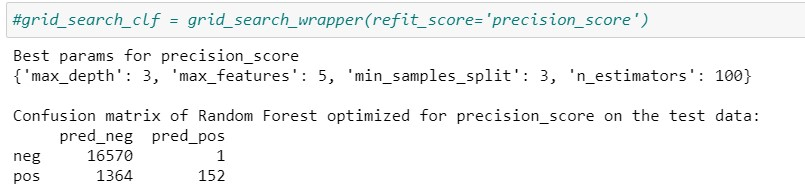

Guardamos los resultados porque tarda mucho en ejecutarse

In [105]:
#dump(grid_search_clf, '../data/resultados_gridsearch_modelos.joblib') 

Importamos los resultados

In [106]:
grid_search_clf = load('../data/resultados_gridsearch_modelos.joblib') 

In [107]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)

In [108]:
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
27,1.0,0.063,0.920,5,3,5,300
6,1.0,0.066,0.920,3,5,3,100
29,1.0,0.068,0.920,5,3,10,300
9,1.0,0.081,0.921,3,5,5,300
7,1.0,0.066,0.920,3,5,3,300


Ajustando límite de decisión

In [109]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]

In [110]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [111]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    #plt.ylim([0.5, 1.01]);
    #plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg     16570         1
pos      1364       152


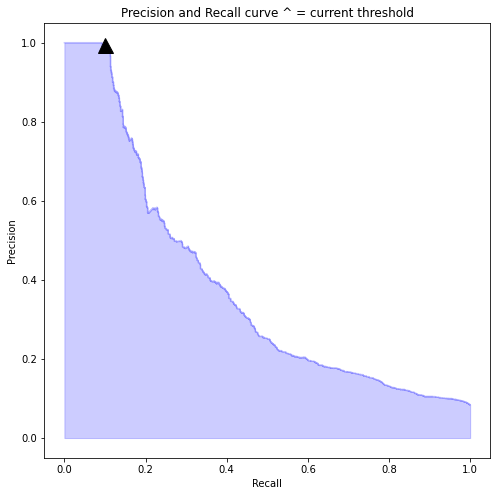

In [112]:
precision_recall_threshold(p, r, thresholds, 0.50)

Another way...

In [113]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

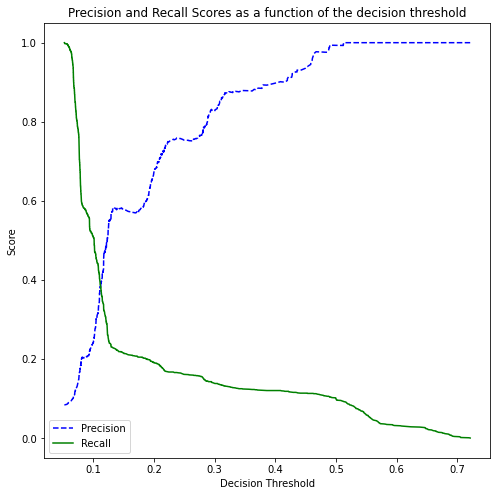

In [114]:
plot_precision_recall_vs_threshold(p, r, thresholds)

In [115]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.7610280636181497


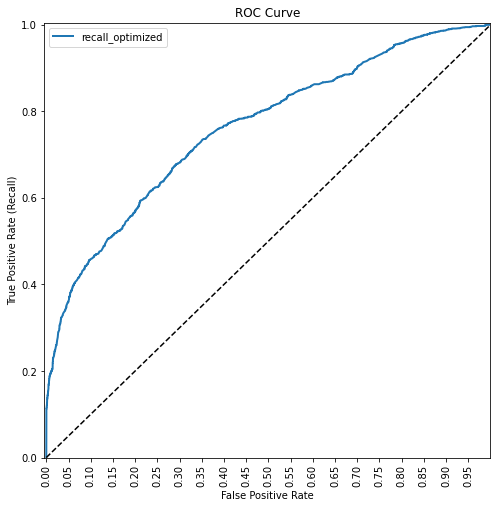

In [116]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

Es necesario entender bien el código anterior para explicar conclusiones y poder hacer los plots con plotly

In [117]:
y_pred = grid_search_clf.predict(X_test) 

In [118]:
import plotly.figure_factory as ff
z = confusion_matrix(y_test, y_pred)

# Reformateo la matriz para que me quede mejor el gráfico
z[[0,1],:] = z[[1,0],:]

x = ['Predicted Not Promoted', 'Predicted promotions']
y = ['True Promoted', 'True Not Promoted']

z_text = [[str(y) for y in x] for x in z]

heatmap = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='cividis')

heatmap.show()

# Predicción con una entrada individual

Se prueba ahora cómo sería la predicción de una entrada individual. Esto se añadirá al dashboard

In [119]:
df_model[(df_model["no_of_trainings"] == 1) &  (df_model["age"] == 24) &  (df_model["gender"] == "m") & (df_model["previous_year_rating"] == 4.0) & (df_model["length_of_service"] == 2) & (df_model["avg_training_score"] == 54)]

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
47235,30698,Sales & Marketing,region_31,NA,m,other,1,24,4.0,2,0,54.0,0


In [120]:
df_model[df_model["employee_id"]==30698]

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
47235,30698,Sales & Marketing,region_31,NA,m,other,1,24,4.0,2,0,54.0,0


Contamos con un registro de un individuo

In [121]:
X_test_pre_transform.head(1)

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_0,department_1,department_2,department_3,...,department_7,department_8,education_0,education_1,education_2,education_3,gender_0,recruitment_channel_0,recruitment_channel_1,recruitment_channel_2
47235,1,24,4.0,2,0,54.0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,0


Este es el registro numérico existente en X_test después de haber pasado por la normalización

In [122]:
X_test[0,:]

array([-0.41918461, -1.41823987,  0.5720871 , -0.90735651, -0.1567848 ,
       -0.72168957, -0.33120613, -0.22018725, -0.21176117, -0.13869044,
       -0.51048061, -0.38670784, -0.13444874,  1.49596053, -0.38605617,
       -1.42778157, -0.11761011, -0.61107701,  4.68514941,  0.65111971,
        0.89544151, -0.14459216, -0.85889253])

Se obtienen los valores numéricos del registro

In [123]:
example_registry = X_test_pre_transform.iloc[0,:]
example_registry.values

array([ 1., 24.,  4.,  2.,  0., 54.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.])

Los ponemos en el formato correcto

In [124]:
example_registry_correct_format = example_registry.values.reshape(1,-1)
example_registry_correct_format.shape

(1, 23)

Se transforman con el escalado correspondiente

In [125]:
example_registry_transformed = sc.transform(example_registry_correct_format)
example_registry_transformed

array([[-0.41918461, -1.41823987,  0.5720871 , -0.90735651, -0.1567848 ,
        -0.72168957, -0.33120613, -0.22018725, -0.21176117, -0.13869044,
        -0.51048061, -0.38670784, -0.13444874,  1.49596053, -0.38605617,
        -1.42778157, -0.11761011, -0.61107701,  4.68514941,  0.65111971,
         0.89544151, -0.14459216, -0.85889253]])

Y se hace la predicción con el modelo generado

In [126]:
example_prediction = grid_search_clf.predict(example_registry_transformed)
example_prediction

array([0], dtype=int64)

Vemos que el ID `47235` está correctamente identificado como NO PROMOCIONA

In [127]:
y_test

47235    0
86       0
13878    0
12473    0
53518    0
        ..
17477    0
45174    0
53672    0
31761    0
49165    0
Name: is_promoted, Length: 18087, dtype: int64

In [128]:
example_prediction_prob = grid_search_clf.predict_proba(example_registry_transformed)
example_prediction_prob

array([[0.93892142, 0.06107858]])

# Modelando el caso de uso del dashboard

In [129]:
entrada = df_model[df_model["employee_id"]==30698]
entrada

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
47235,30698,Sales & Marketing,region_31,NA,m,other,1,24,4.0,2,0,54.0,0


In [130]:
no_of_trainings = entrada["no_of_trainings"]
age = entrada["age"]
length_of_service = entrada["length_of_service"]
avg_training_score = entrada["avg_training_score"]
awards_won = entrada["awards_won"]
genero = entrada["gender"]
departamento = entrada["department"]
educacion = entrada["education"]
recruitment = entrada["recruitment_channel"]
previous_year_rating = entrada["previous_year_rating"]

In [131]:
no_of_trainings = 1
age = 24
length_of_service = 2
avg_training_score = 54.0
awards_won = 0
genero = "m"
departamento = "Sales & Marketing"
educacion = "NA"
recruitment = "other"
previous_year_rating = 4.0

Lo tenemos que transformar en:

In [132]:
X_test_pre_transform.head(1)

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_0,department_1,department_2,department_3,...,department_7,department_8,education_0,education_1,education_2,education_3,gender_0,recruitment_channel_0,recruitment_channel_1,recruitment_channel_2
47235,1,24,4.0,2,0,54.0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,0


In [133]:
sc = load('../data/standard_scaler_modelos.joblib')
encoder_department = load('../data/encoder_variable_department.joblib')
encoder_education = load('../data/encoder_variable_education.joblib')
encoder_gender = load('../data/encoder_variable_gender.joblib')
encoder_recruitment_channel = load(
    '../data/encoder_variable_recruitment_channel.joblib')

In [134]:
department_encoded = encoder_department.transform([departamento])
department_encoded

array([[0, 0, 0, 0, 0, 0, 0, 1, 0]])

In [135]:
education_encoded = encoder_education.transform([educacion])
education_encoded.flatten()

array([0, 0, 0, 1])

In [136]:
gender_encoded = encoder_gender.transform([genero])
gender_encoded

array([[1]])

In [137]:
recruitment_encoded = encoder_recruitment_channel.transform([recruitment])
recruitment_encoded

array([[1, 0, 0]])

In [138]:
encoded_entry = np.concatenate(([no_of_trainings, age, previous_year_rating, length_of_service, awards_won, avg_training_score], department_encoded.flatten(), education_encoded.flatten(), gender_encoded.flatten(), recruitment_encoded.flatten()))

In [139]:
encoded_entry

array([ 1., 24.,  4.,  2.,  0., 54.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.])

In [140]:
scaled_entry = sc.transform(encoded_entry.reshape(1,-1))
scaled_entry

array([[-0.41918461, -1.41823987,  0.5720871 , -0.90735651, -0.1567848 ,
        -0.72168957, -0.33120613, -0.22018725, -0.21176117, -0.13869044,
        -0.51048061, -0.38670784, -0.13444874,  1.49596053, -0.38605617,
        -1.42778157, -0.11761011, -0.61107701,  4.68514941,  0.65111971,
         0.89544151, -0.14459216, -0.85889253]])

Comprobamos con el resultado de arriba para comprobar que todo ha salido correctamente

In [141]:
scaled_entry - example_registry_transformed

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]])

OK!

In [142]:
prediction = grid_search_clf.predict(scaled_entry)

In [143]:
probability = grid_search_clf.predict_proba(scaled_entry)

In [144]:
prediction[0]

0

In [145]:
probability[0][1].astype(float)

0.06107857687410685

In [146]:
probability

array([[0.93892142, 0.06107858]])

In [147]:
round(probability[0][1].astype(float),2)

0.06

In [148]:
float(probability[0][1])

0.06107857687410685